In [5]:
import adaptive_latents as al
from adaptive_latents import NumpyTimedDataSource, Bubblewrap, AnimationManager, default_rwd_parameters, BWRun
from adaptive_latents.plotting_functions import show_bubbles_2d, show_nstep_pdf
import matplotlib.pyplot as plt
import numpy as np
rng = np.random.default_rng()
from tqdm import trange
from scipy.integrate import solve_ivp

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


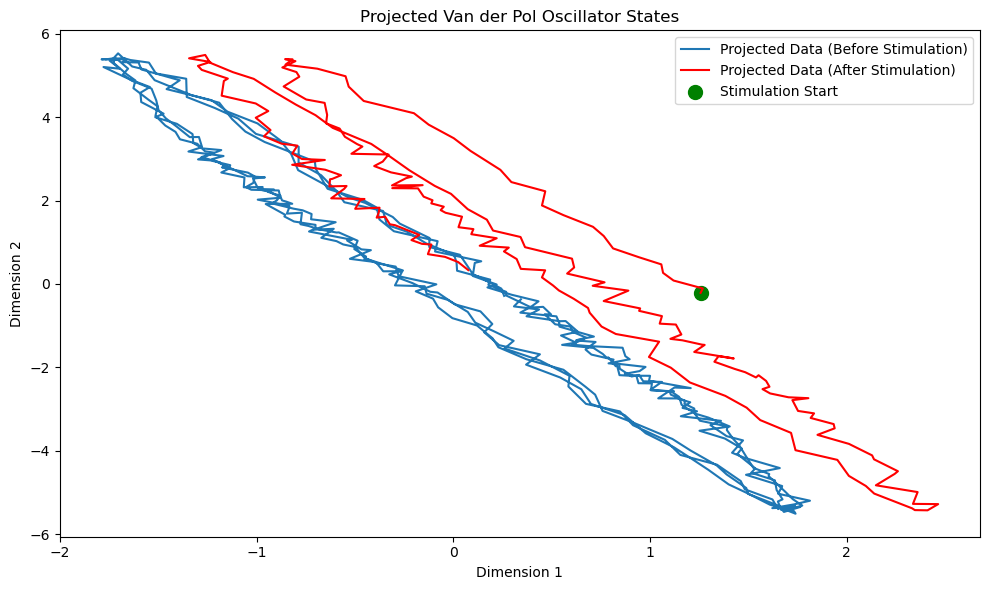

In [6]:
# Define the Van der Pol oscillator function
def vdp(t, f, mu=1.0):
    x, y = f
    x_dot = y
    y_dot = mu * (1 - x**2) * y - x
    return [x_dot, y_dot]

# Define the random projection function
def random_proj(initial_dim: int, dim: int, seed=4):
    rand = np.random.default_rng(seed)
    t = rand.normal(0, 1, size=(dim, initial_dim))
    return (t / np.sum(t, axis=0)).T

# Define the stimulation function
def stimulation(t, start_time, amplitude, decay_rate):
    if t < start_time:
        return 0
    return amplitude * np.exp(-decay_rate * (t - start_time))

# Define the data generation function with stimulation
def gen_data_diffeq(f, projection, t, x0, dim, ivp_kwargs=None, proj_kwargs=None, noise=None, noise_kwargs=None, seed=41,
                    stim_start_time=0, stim_amplitude=1.0, stim_decay_rate=0.1):
    if ivp_kwargs is None:
        ivp_kwargs = {}
    if proj_kwargs is None:
        proj_kwargs = {}
    if noise_kwargs is None:
        noise_kwargs = {}
        
    ivp = solve_ivp(f, t, x0, rtol=1e-6, **ivp_kwargs)
    
    y = ivp['y'].T
    proj = projection(y.shape[1], dim, **proj_kwargs)
    projed = y @ proj
    
    if noise is not None:
        rand = np.random.default_rng(seed)
        projed += getattr(rand, noise)(**noise_kwargs, size=projed.shape)
    
    # Apply stimulation to the projected data
    stim = np.array([stimulation(ti, stim_start_time, stim_amplitude, stim_decay_rate) for ti in ivp['t']])
    projed[:, 0] += stim  # Assuming the stimulation affects the first dimension
    
    return ivp['t'], y, projed

# Define the function to generate datasets
def make_dataset(f, x0, num_trajectories, num_dim, begin, end, noise, stim_timestep=600, stim_amplitude=1.0, stim_decay_rate=0.1):
    xx = []
    projeds = []
    rng = np.random.RandomState(39)
    
    for _ in trange(num_trajectories):
        t, x, projed = gen_data_diffeq(f, random_proj,
                                       t=(0, 125), x0=x0 + 0.01 * rng.randn(*x0.shape), dim=num_dim, noise="normal",
                                       ivp_kwargs={'max_step': 0.05},
                                       noise_kwargs={"loc": 0, "scale": noise},
                                       stim_start_time=0, stim_amplitude=0, stim_decay_rate=0)
        t = t[begin:end]
        # Calculate the actual start time for stimulation
        stim_start_time = t[stim_timestep - begin]
        # Regenerate the data with the correct stimulation start time
        t, x, projed = gen_data_diffeq(f, random_proj,
                                       t=(0, 125), x0=x0 + 0.01 * rng.randn(*x0.shape), dim=num_dim, noise="normal",
                                       ivp_kwargs={'max_step': 0.05},
                                       noise_kwargs={"loc": 0, "scale": noise},
                                       stim_start_time=stim_start_time, stim_amplitude=stim_amplitude, stim_decay_rate=stim_decay_rate)
        t = t[begin:end]
        xx.append(x[begin:end])
        projeds.append(projed[begin:end])
    
    xx = np.stack(xx, axis=0)
    projeds = np.stack(projeds, axis=0)
    
    xs = xx
    ys = projeds
    us = np.zeros((xx.shape[0], xx.shape[1], 1))
    
    return xs, ys

# Generate data using the Van der Pol oscillator with stimulation
x0 = np.array([0.1, 0.1])
num_trajectories = 1
num_dim = 2
begin, end = 500, 1100
noise = 0.05
stim_timestep = 900
stim_amplitude = 1.0
stim_decay_rate = 0.1

xs, ys = make_dataset(vdp, x0, num_trajectories, num_dim, begin, end, noise, stim_timestep, stim_amplitude, stim_decay_rate)

# Plot the results
plt.figure(figsize=(10, 6))

# Find the index where stimulation starts
stim_index = stim_timestep - begin

# Plot the projected states
plt.plot(ys[0, :stim_index, 0], ys[0, :stim_index, 1], label='Projected Data (Before Stimulation)')
plt.plot(ys[0, stim_index:, 0], ys[0, stim_index:, 1], label='Projected Data (After Stimulation)', color='red')

# Plot a green dot where the red plot starts
plt.scatter(ys[0, stim_index, 0], ys[0, stim_index, 1], color='green', s=100, label='Stimulation Start')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Projected Van der Pol Oscillator States')
plt.legend()

plt.tight_layout()
plt.show()

 17%|█▋        | 99/599 [00:02<00:10, 46.64it/s]


XlaRuntimeError: INTERNAL: cuSolver internal error

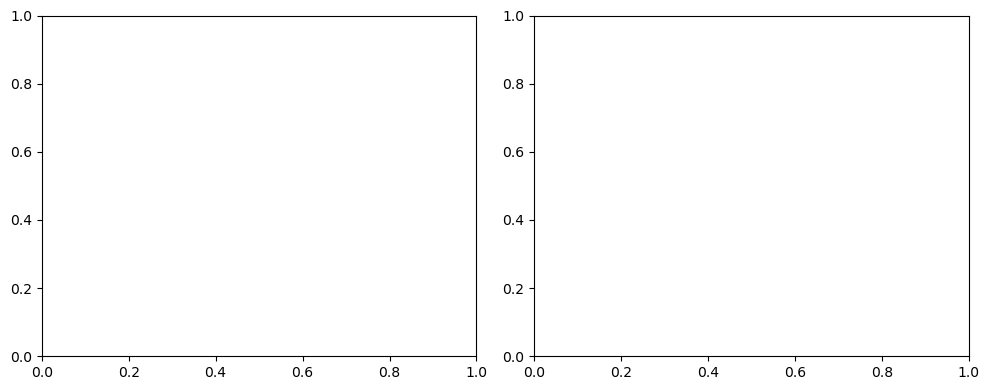

In [7]:
# Use the generated data with Bubblewrap and AnimationManager
t = np.arange(ys.shape[1])
in_ds = NumpyTimedDataSource(ys[0], t, time_offsets=(0,1))

default_rwd_parameters = {
    # Add necessary parameters here
    # Example: 'param_name': value
}

bw = Bubblewrap(dim=in_ds.output_shape, **dict(default_rwd_parameters, M=100, num=20, B_thresh=-5, num_grad_q=4))

class CustomAnimation(AnimationManager):
    n_rows = 1
    n_cols = 2
    figsize = (10,4)
    extension = "mp4"
    fps = 20

    def custom_draw_frame(self, step, bw: Bubblewrap, br: BWRun):
        historical_observations, _ = br.input_ds.get_history()

        show_bubbles_2d(self.ax[0,0], historical_observations, bw, show_names=False, tail_length=5)
        show_nstep_pdf(self.ax[0,1], br, self.ax[0,0], self.fig, offset=1, show_colorbar=False)
        #show_nstep_pdf(self.ax[0,2], br, self.ax[0,0], self.fig, hmm=None, method="hmm", offset=1, show_colorbar=False)
        self.ax[0,0].set_title("data and bubbles")
        #self.ax[0,2].set_title("1-step true prob.")
        self.ax[0,1].set_title("1-step predicted prob.")

        for ax in self.ax[0,:]:
            ax.axis("off")
    
    def frame_draw_condition(self, step_number, bw):
        condition = True
        condition = condition and 0 < step_number < 800
        return condition

am = CustomAnimation() if True else None

br = BWRun(bw=bw, in_ds=in_ds, animation_manager=am, show_tqdm=True)

br.run(limit=1000, save=True)